In [36]:
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('playground-series-s5e8/train.csv')

In [38]:
X = df.drop(['y', 'id'], axis=1)
y = df['y']

<Axes: >

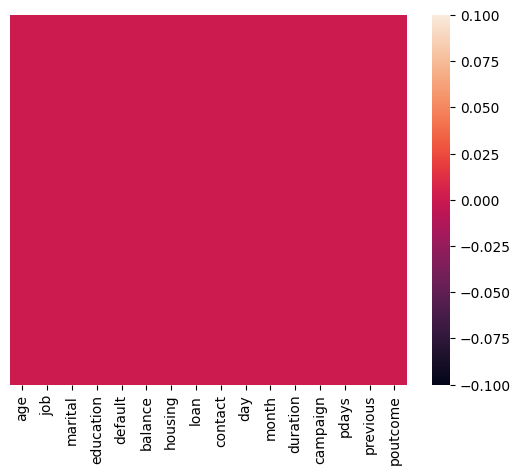

In [39]:
import seaborn as sns
sns.heatmap(X.isnull(), yticklabels=False)

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
dtypes: int64(7), object(9)
memory usage: 91.6+ MB


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
num_category = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
encode = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
columnTransform = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_category),
        ('encode', OneHotEncoder(), encode)
    ]
)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=101)

In [44]:
X_train = columnTransform.fit_transform(X_train)
X_val = columnTransform.transform(X_val)

In [45]:
from sklearn.utils import class_weight
import numpy as np

# y_train should be your labels
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weights = dict(zip(classes, weights))
print(class_weights)

{np.int64(0): np.float64(0.5688775233781572), np.int64(1): np.float64(4.129631086289625)}


In [46]:
models = Sequential()

models.add(Dense(64, activation='relu'))
models.add(Dropout(0.2))
models.add(Dense(32, activation='relu'))
models.add(Dense(1, activation='sigmoid'))

adam_optim = Adam(learning_rate=0.0001)
models.compile(optimizer=adam_optim, loss='binary_crossentropy', metrics=['AUC'])

earlyStop = EarlyStopping(monitor='val_AUC', patience=25, mode='max')

models.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=earlyStop, epochs=300, batch_size=2048, class_weight=class_weights)

Epoch 1/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8316 - loss: 0.5727 - val_AUC: 0.9203 - val_loss: 0.4967
Epoch 2/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9162 - loss: 0.4011 - val_AUC: 0.9346 - val_loss: 0.3647
Epoch 3/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9303 - loss: 0.3395 - val_AUC: 0.9399 - val_loss: 0.3418
Epoch 4/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9348 - loss: 0.3235 - val_AUC: 0.9426 - val_loss: 0.3349
Epoch 5/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9378 - loss: 0.3131 - val_AUC: 0.9444 - val_loss: 0.3215
Epoch 6/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9396 - loss: 0.3062 - val_AUC: 0.9457 - val_loss: 0.3198
Epoch 7/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9411 - loss: 0.3007 - val_AUC: 0.9467 - val_loss: 0.3149
Epoch 8/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9425 - loss: 0.2960 - val_AUC: 0.9475 - val_loss: 0.3125
Epoch 9/300
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/

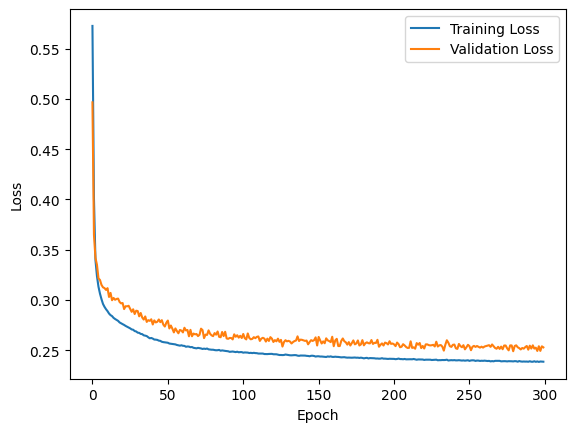

In [47]:
losses = pd.DataFrame(models.history.history)
plt.plot(losses['loss'], label='Training Loss')
plt.plot(losses['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

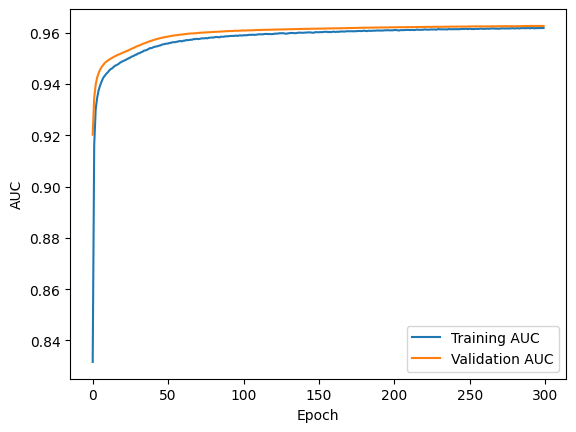

In [48]:
plt.plot(losses['AUC'], label='Training AUC')
plt.plot(losses['val_AUC'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [49]:
predicted=models.predict(X_val)


7032/7032 ━━━━━━━━━━━━━━━━━━━━ 4s 555us/step


In [50]:
predicted = (predicted>0.5).astype(int)

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_val, predicted))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93    198077
           1       0.49      0.94      0.65     26923

    accuracy                           0.88    225000
   macro avg       0.74      0.90      0.79    225000
weighted avg       0.93      0.88      0.89    225000



In [52]:
test = pd.read_csv('playground-series-s5e8/test.csv')

In [53]:
test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [54]:
testValues = columnTransform.transform(test.drop('id', axis=1))

In [55]:
pred=models.predict(testValues)

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 4s 565us/step


In [56]:
pred=pred.flatten()

In [57]:
submission = pd.DataFrame({
    'id':test['id'],
    'y':pred
})

submission.to_csv('submission10.csv', index=False)

In [58]:
import joblib

# Suppose your ColumnTransformer is called `preprocessor`
joblib.dump(columnTransform, 'preprocessor.pkl')

['preprocessor.pkl']

In [59]:
models.save('tensorflow_model.h5')